# Algorithms Performance Analysis

## Configurations Table

| Number | Grid Size | Number of Drones | Drones Initial Positions | Disperse Constant | Time Step Limit | Person Initial Position
| --- | --- | --- | --- | --- | --- | --- |
| 1 | 20x20 | 1 | (0,0) | 3 | 100 | (9,9) |
| 2 | 20x20 | 2 | (0,0), (19, 19) | 3 | 100 | (9,9) |
| 3 | 20x20 | 4 | (0,0), (19, 19), (0, 19), (19, 0) | 3 | 100 | (9,9) |



## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from DSSE.core.environment.env import DroneSwarmSearch
import csv

## Importing Necessary Modules

In [3]:
from config import get_config
from algorithms.reinforce_gpu import Reinforce
from greedy_test import run_one_episode_greedy

## Load Data

In [4]:
def load_data(config):
    statistics = pd.read_csv(
        f"data_new/statistics_{config.grid_size}_{config.n_drones}_{config.disperse_constant}_new.csv"
    )
    nn = torch.load(
        f"data_new/nn_{config.grid_size}_{config.n_drones}_{config.disperse_constant}_new.pt"
    )

    return statistics, nn

## Plotting Learning Curves

In [5]:
def plot_learning_curve(statistics, n_config):
    config = get_config(n_config)
    num_drones = config.n_drones
    disperse_constant = config.disperse_constant
    _, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    # Plot mean rewards considering a window of 500 episodes
    ax1.plot(
        statistics["episode"],
        statistics["rewards"].rolling(500).mean(),
        "r-",
        label="Mean Rewards",
    )
    ax1.set_ylabel("Mean Rewards")

    # Plot mean actions considering a window of 500 episodes

    # Divide actions by the number of drones to get the mean number of actions per drone
    statistics["actions"] = statistics["actions"] / num_drones

    ax2.plot(
        statistics["episode"],
        statistics["actions"].rolling(500).mean(),
        "b-",
        label="Mean Actions",
    )
    ax2.set_ylabel("Mean Actions")

    # Legend, title and labels
    ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.0)
    ax2.legend(loc="upper right", bbox_to_anchor=(1.235, 0.95), borderaxespad=0.0)
    plt.title(f"Learning Curve - {num_drones = }, {disperse_constant = }")
    ax1.set_xlabel("Episodes")
    plt.grid()
    plt.savefig(f"imgs/learning_curve_nd{num_drones}_dc{disperse_constant}.png", dpi=300)
    plt.show()

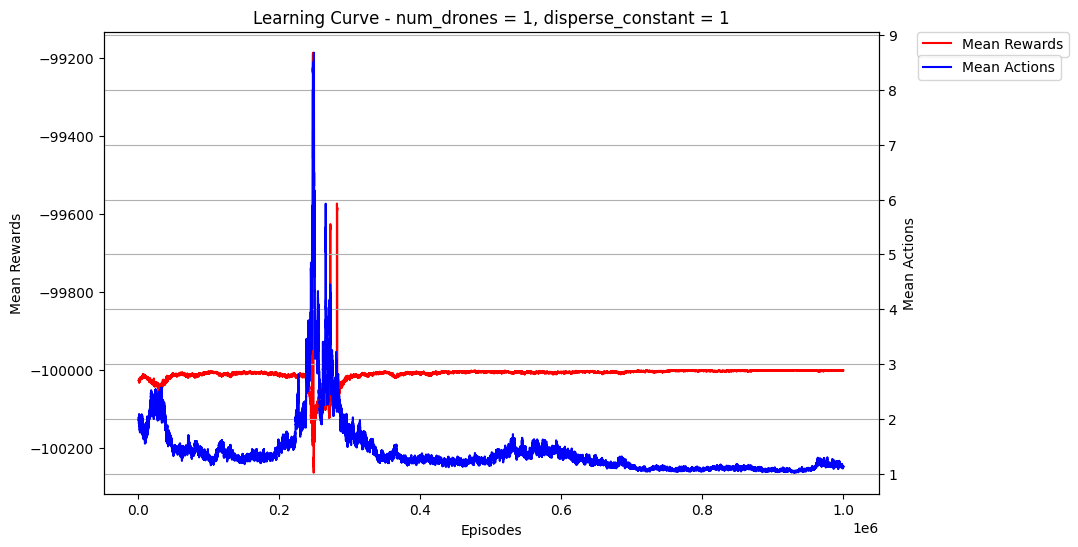

In [6]:
config_1 = get_config(1)
statistics_config_1, nn_config_1 = load_data(config_1)
plot_learning_curve(statistics_config_1, 1)

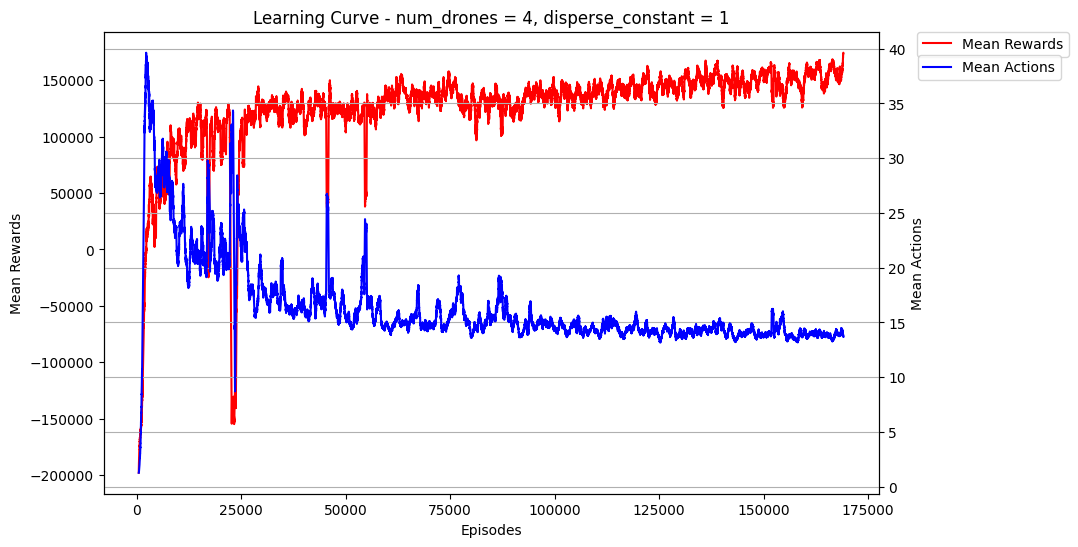

In [7]:
config_2 = get_config(2)
statistics_config_2, nn_config_2 = load_data(config_2)
plot_learning_curve(statistics_config_2, 2)

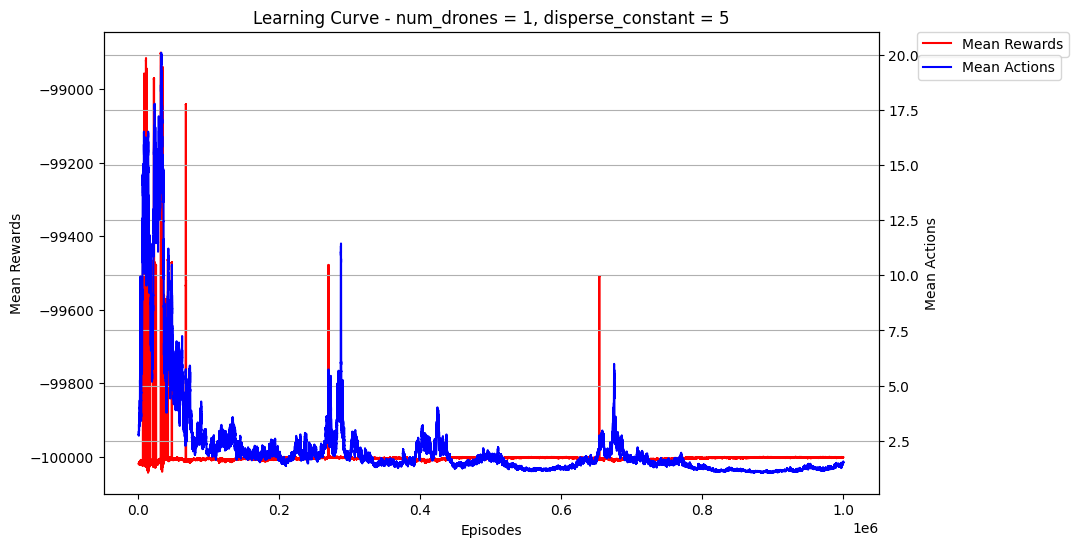

In [8]:
config_3 = get_config(3)
statistics_config_3, nn_config_3 = load_data(config_3)
plot_learning_curve(statistics_config_3, 3)

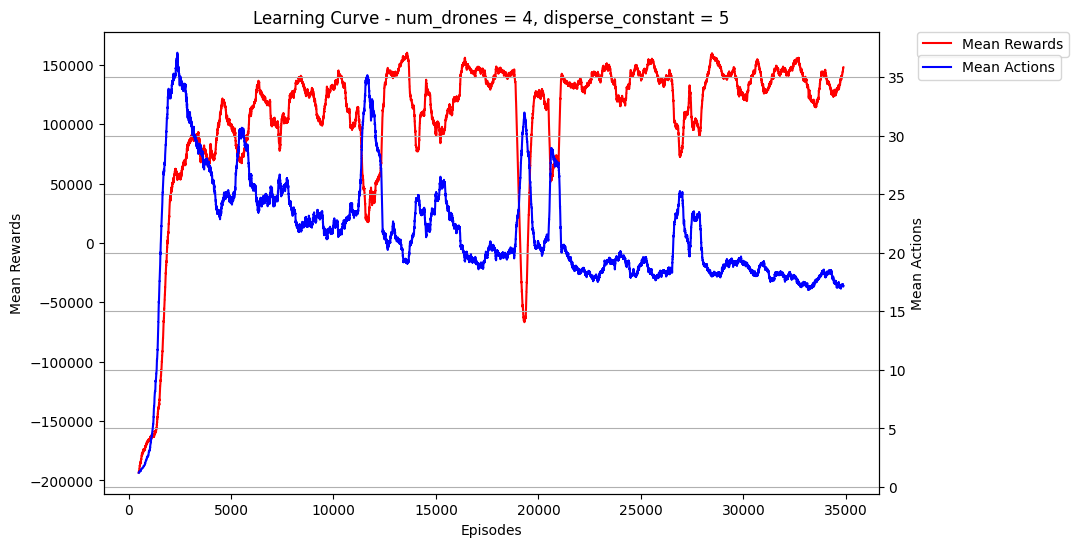

In [9]:
config_4 = get_config(4)
statistics_config_4, nn_config_4 = load_data(config_4)
plot_learning_curve(statistics_config_4, 4)

##  Comparing Algorithms - Collecting Data

In [10]:
def instantiate_env(config_number=1):
    config = get_config(config_number)
    env = DroneSwarmSearch(
        grid_size=config.grid_size,
        render_mode="ansi",
        render_grid=False,
        render_gradient=False,
        n_drones=config.n_drones,
        person_initial_position=config.person_initial_position,
        disperse_constant=config.disperse_constant,
        timestep_limit=config.timestep_limit,
    )
    return env


def get_random_speed_vector():
    return [
        round(np.random.uniform(-0.1, 0.1), 1),
        round(np.random.uniform(-0.1, 0.1), 1),
    ]


def run_one_episode_reinforce(env, nn, config_number=1):
    config = get_config(config_number)
    reinforce = Reinforce(env=env)
    episode_actions = {}
    state = env.reset(
        vector=reinforce.get_random_speed_vector(),
    )
    obs_list = reinforce.flatten_state(state)
    steps_count = 0
    total_reward = 0
    done = False

    while not done:
        for drone_index in range(len(env.possible_agents)):
            probs = nn(obs_list[drone_index].float())
            dist = torch.distributions.Categorical(probs)
            episode_actions[f"drone{drone_index}"] = dist.sample().item()

        obs_list_, reward_dict, _, done, info = env.step(episode_actions)
        obs_list = reinforce.flatten_state(obs_list_)
        done = any(done.values())

        total_reward += reward_dict["total_reward"]
        steps_count += 1

    return total_reward, steps_count, info["Found"]

# def run_one_episode_parallel_sweep(env, config_number=1):
#     config = get_config(config_number)
#     env.reset(
#         drones_positions=config.drones_initial_positions,
#         vector=get_random_speed_vector(),
#     )
#     algorithm = MultipleParallelSweep(env)
#     reward, steps, found = algorithm.run()
#     return reward, steps, found

In [11]:
run_one_episode_reinforce(instantiate_env(1), nn_config_1, 1)

(-100000, 1, False)

In [12]:
run_one_episode_greedy(instantiate_env(1), 1)

(191193.10490860452, 13, True)

In [16]:
def collect_algorithms_data(config_number=1):
    config = get_config(config_number)
    env = instantiate_env(config_number)
    nn = torch.load(
        f"data_new/nn_{config.grid_size}_{config.n_drones}_{config.disperse_constant}_new.pt"
    )

    filename = (
        f"data_new/results_{config.grid_size}_{config.n_drones}_{config.disperse_constant}_new.csv"
    )
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(
            [
                "Reinforce Rewards",
                "Reinforce Steps",
                "Reinforce Found",
                "Greedy Rewards",
                "Greedy Steps",
                "Greedy Found",
            ]
        )
        n_episodes = 10_000
        for i in range(n_episodes):
            print(f"In episode {i}/{n_episodes} - {config_number}")
            (
                reinforce_reward,
                reinforce_steps,
                reinforce_found,
            ) = run_one_episode_reinforce(env, nn, config_number)
            (
                greedy_reward,
                greedy_steps,
                greedy_found,
            ) = run_one_episode_greedy(env, config_number)

            writer.writerow(
                [
                    reinforce_reward,
                    reinforce_steps,
                    reinforce_found,
                    greedy_reward,
                    greedy_steps,
                    greedy_found,
                ]
            )

    print(f"Data saved to {filename}")

In [17]:
collect_algorithms_data(2)

In episode 0/10000 - 2
In episode 1/10000 - 2
In episode 2/10000 - 2
In episode 3/10000 - 2
In episode 4/10000 - 2
In episode 5/10000 - 2
In episode 6/10000 - 2
In episode 7/10000 - 2
In episode 8/10000 - 2
In episode 9/10000 - 2
In episode 10/10000 - 2
In episode 11/10000 - 2
In episode 12/10000 - 2
In episode 13/10000 - 2
In episode 14/10000 - 2
In episode 15/10000 - 2
In episode 16/10000 - 2
In episode 17/10000 - 2
In episode 18/10000 - 2
In episode 19/10000 - 2
In episode 20/10000 - 2
In episode 21/10000 - 2
In episode 22/10000 - 2
In episode 23/10000 - 2
In episode 24/10000 - 2
In episode 25/10000 - 2
In episode 26/10000 - 2
In episode 27/10000 - 2
In episode 28/10000 - 2
In episode 29/10000 - 2
In episode 30/10000 - 2
In episode 31/10000 - 2
In episode 32/10000 - 2
In episode 33/10000 - 2
In episode 34/10000 - 2
In episode 35/10000 - 2
In episode 36/10000 - 2
In episode 37/10000 - 2
In episode 38/10000 - 2
In episode 39/10000 - 2
In episode 40/10000 - 2
In episode 41/10000 - 2
In

In [18]:
collect_algorithms_data(4)

In episode 0/10000 - 4
In episode 1/10000 - 4
In episode 2/10000 - 4
In episode 3/10000 - 4
In episode 4/10000 - 4
In episode 5/10000 - 4
In episode 6/10000 - 4
In episode 7/10000 - 4
In episode 8/10000 - 4
In episode 9/10000 - 4
In episode 10/10000 - 4
In episode 11/10000 - 4
In episode 12/10000 - 4
In episode 13/10000 - 4
In episode 14/10000 - 4
In episode 15/10000 - 4
In episode 16/10000 - 4
In episode 17/10000 - 4
In episode 18/10000 - 4
In episode 19/10000 - 4
In episode 20/10000 - 4
In episode 21/10000 - 4
In episode 22/10000 - 4
In episode 23/10000 - 4
In episode 24/10000 - 4
In episode 25/10000 - 4
In episode 26/10000 - 4
In episode 27/10000 - 4
In episode 28/10000 - 4
In episode 29/10000 - 4
In episode 30/10000 - 4
In episode 31/10000 - 4
In episode 32/10000 - 4
In episode 33/10000 - 4
In episode 34/10000 - 4
In episode 35/10000 - 4
In episode 36/10000 - 4
In episode 37/10000 - 4
In episode 38/10000 - 4
In episode 39/10000 - 4
In episode 40/10000 - 4
In episode 41/10000 - 4
In